In [61]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import TimeSeriesSplit,cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [62]:
print("Working with these versions of libraries\n")
print("-"*50)
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

--------------------------------------------------
Numpy version 1.26.4
Pandas version 1.5.1
XGBoost version 1.3.3


In [63]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "data")

# DATA_PATH = ""

FILE_NAME = "ts_kaggle_train.csv"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, FILE_NAME)

In [64]:
df= pd.read_csv((TRAIN_CSV_PATH),index_col=0)

In [65]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0


**Objetivo: En base a los meses que disponemos en el dataset, sacar la predicción de 'monthly_sale' del mes que viene.**

In [66]:
df['date']= pd.to_datetime(df['date'], format='%Y-%m-%d')

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14484 non-null  datetime64[ns]
 1   unique_id              14484 non-null  object        
 2   city_id                14484 non-null  int64         
 3   shop_id                14484 non-null  int64         
 4   item_category_id       14484 non-null  int64         
 5   item_id                14484 non-null  int64         
 6   monthly_average_price  13262 non-null  float64       
 7   monthly_sales          13756 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1018.4+ KB


In [68]:
# conocer fechas unicas. 33 para entrenar 1 para predecir
df['date'].nunique()

34

In [69]:
# Series temproales únicas
df['unique_id'].nunique()

426

In [70]:
df.describe()

,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
count,14484.000000,14484.000000,14484.000000,14484.000000,13262.000000,13756.000000
mean,10.833333,31.967136,39.356808,8626.431925,916.089314,7.337889
std,6.227364,15.236351,20.439654,5905.273346,820.945949,7.915032
min,0.000000,3.000000,2.000000,32.000000,4.928571,0.000000
25%,7.000000,22.000000,30.000000,4248.000000,299.000000,2.000000
50%,7.000000,31.000000,35.000000,6457.000000,649.000000,5.000000
75%,16.000000,44.000000,55.000000,12551.000000,1149.000000,9.000000
max,23.000000,59.000000,83.000000,22088.000000,9305.121212,30.000000


In [71]:
df.isnull().sum()

date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

Df de ventas, un caso transaccional. En este caso yo puedo identificar nulos de 2 formas. 
- 1. Si isnull()
- 2. Si el 'monthly_sales' = 0

<Axes: >

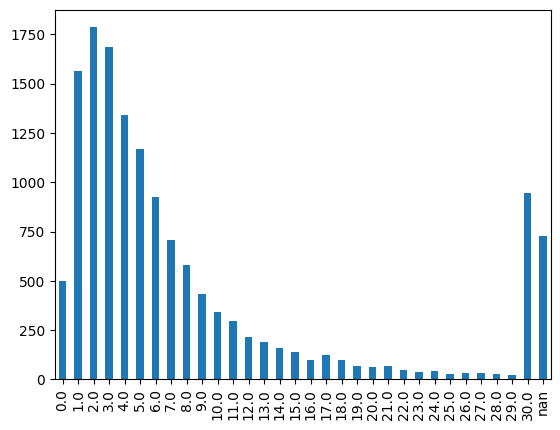

In [72]:
(
    df
    ['monthly_sales']
    .value_counts(dropna= False)
    .sort_index()
    .plot(kind='bar')

)

In [73]:
import seaborn as sns
import numpy as np

In [74]:
pt= (
    df
    .pivot_table(
        index= 'date',
        columns= 'unique_id',
        values= 'monthly_sales',
        aggfunc='sum'
    
    )
    .replace(
        {
            0:np.nan
        }
    
    )
#     .isnull()
    .notnull()
)

<Axes: xlabel='unique_id', ylabel='date'>

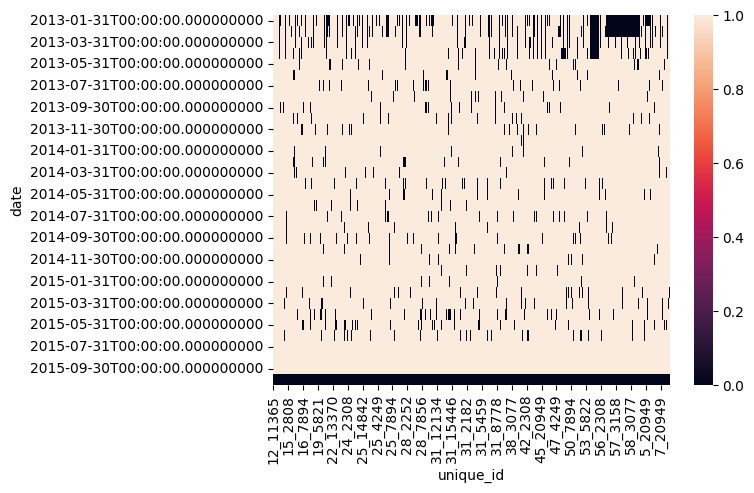

In [75]:
sns.heatmap(pt)

**Importante esto:** comprobar si mis series temporales estan completas (todos productos y todas las fechas, están todas las combinaciones) 

**Por eso chequeo fundamental:**

In [76]:
df.shape

(14484, 8)

In [77]:
df['unique_id'].nunique()

426

In [78]:
df['date'].nunique()

34

In [79]:
426 * 34

14484

De partida están todos los registros posible. (14484)

Aquí tenemos nuestro primer EDA, minicontacto con el dataset. **Pero mi objetivo inicial** es tener un codigo que yo pueda correr de principio a fin, 1 lines(importo dataset), última (predicción)

Veamos cuales son las fechas min y max de nuestro dataset:

In [80]:
MIN_DATE= df['date'].min()
MAX_DATE= df['date'].max()

In [81]:
print (f'Min date is {MIN_DATE}\nMax date is {MAX_DATE}')

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


In [82]:
df.isnull().sum()

date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

## Preprocessing

In [83]:
sample_ts= '31_4249'

In [84]:
df[df['unique_id']==sample_ts]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0


In [85]:
df.fillna({
    'monthly_sales':0
}, inplace= True)

In [86]:
df['monthly_average_price']=(
    df.groupby('unique_id',group_keys=False)
    ['monthly_average_price'].apply(
        lambda series: series.interpolate().ffill().bfill()
    )
)

# df['monthly_average_price']=(
#     df.groupby('unique_id',group_keys=False)
#     ['monthly_average_price'].apply(
#         lambda series: series.bfill().ffill()
#     )
# )

In [87]:
df.sort_values(['unique_id','date'], ascending= True, inplace= True)

In [88]:
df[df['unique_id']==sample_ts]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14484 non-null  datetime64[ns]
 1   unique_id              14484 non-null  object        
 2   city_id                14484 non-null  int64         
 3   shop_id                14484 non-null  int64         
 4   item_category_id       14484 non-null  int64         
 5   item_id                14484 non-null  int64         
 6   monthly_average_price  14484 non-null  float64       
 7   monthly_sales          14484 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1018.4+ KB


In [90]:
df.isnull().sum()

date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
dtype: int64

In [91]:
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0
...,...,...,...,...,...,...,...,...
14435,2015-06-30,7_7893,21,7,6,7893,2490.000000,1.0
14447,2015-07-31,7_7893,21,7,6,7893,2690.000000,1.0
14459,2015-08-31,7_7893,21,7,6,7893,2490.000000,1.0
14471,2015-09-30,7_7893,21,7,6,7893,2689.900000,5.0


## **EDA:** 
Vamos al notebook de EDA para ver como son nuestras series temporales y coger ideas para futuras variables 

### Build Time Series Features (**CORE IDEA**)

Dado que vamos a tener que iterar muchas veces sobre nuestro dataset, nos interesa tener todo el código encapsulado en funciones para su reutilización.

Uno de los apartados clave será la generación de variables.

Como hemos visto antes, nuestro dataset contiene más de 400 Series Temporales.

Algunas de estas Series Temporales las podemos agrupar para sacar nueva información.

Por ejemplo, podemos construir una variables del estilo:

1. Las ventas totales por ITEM_ID (la menor granularidad posible).
2. Las ganancias totales por ITEM_CATEGORY_ID y SHOP_ID (una granularidad mayor a la 1).
3. Las ventas totales por SHOP_ID (una granularidad mayor).
4. Y todas las combinaciones que queramos intermedias.

In [92]:
df['revenue']=df['monthly_average_price']*df['monthly_sales']

In [93]:
# Extraer mes
df['month'] = df['date'].dt.month

# Codificar de forma circular
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [94]:
# meses bajos y altos de ventas
df['is_low_month'] = df['month'].apply(lambda m: 1 if m in [2,4,5] else 0)
df['is_high_month'] = df['month'].apply(lambda m: 1 if m in [12] else 0)

In [95]:
# ventas globales del mes actual
df['global_monthly_sales'] = (
    df
    .groupby('date')['monthly_sales']
    .transform('sum')
)

In [96]:
# Diferencia de ventas  con el mes/ meses anterior/es
df['monthly_sales_diff_1m'] = df.groupby('unique_id')['monthly_sales'].diff(1)
df['monthly_sales_diff_12m'] = df.groupby('unique_id')['monthly_sales'].diff(12)
# Variación porcentual con el mes anterior
df['monthly_sales_pct_change_1m'] = df.groupby('unique_id')['monthly_sales'].pct_change(1)
df['monthly_sales_pct_change_12m'] = df.groupby('unique_id')['monthly_sales'].pct_change(12)



# Diferencia de ventas globales  con el mes/ meses anterior/es
df['global_monthly_sales_diff_1m'] = df.groupby('unique_id')['global_monthly_sales'].diff(1)
df['global_monthly_sales_diff_12m'] = df.groupby('unique_id')['global_monthly_sales'].diff(12)
# Variación porcentual con el mes anterior
df['global_monthly_sales_pct_change_1m'] = df.groupby('unique_id')['global_monthly_sales'].pct_change(1)
df['global_monthly_sales_pct_change_12m'] = df.groupby('unique_id')['global_monthly_sales'].pct_change(12)


In [97]:
# #Diferencia de monthly_avg_price con el mes/ meses anterior/es
# df['monthly_avg_price_diff_1m'] = df.groupby('unique_id')['monthly_average_price'].diff(1)
# df['monthly_avg_price_diff_12m'] = df.groupby('unique_id')['monthly_average_price'].diff(12)
#  # Variación porcentual con el mes anterior
# df['monthly_avg_price_pct_change_1m'] = df.groupby('unique_id')['monthly_average_price'].pct_change(1)
# df['monthly_avg_price_pct_change_12m'] = df.groupby('unique_id')['monthly_average_price'].pct_change(12)



In [98]:
# # Diferencia de ganancias  con el mes/ meses anterior/es
# df['revenue_diff_1m'] = df.groupby('unique_id')['revenue'].diff(1)
# df['revenue_diff_12m'] = df.groupby('unique_id')['revenue'].diff(12)
# # Variación porcentual con el mes anterior
# df['revenue_pct_change_1m'] = df.groupby('unique_id')['revenue'].pct_change(1)
# df['revenue_sales_pct_change_12m'] = df.groupby('unique_id')['revenue'].pct_change(12)

In [99]:
# df[['date','monthly_sales',	'monthly_sales_diff_1m','monthly_sales_pct_change_1m', 'global_monthly_sales','monthly_sales_diff_12m','monthly_sales_pct_change_12m', 'global_monthly_sales_diff_1m','global_monthly_sales_diff_12m', 'global_monthly_sales_pct_change_1m','global_monthly_sales_pct_change_12m']].head(40)

In [100]:
def build_ts_vars(df,target_column, agg_func, agg_func_name, nr_lags, gb_list= None):
    assert 'date' in df.columns, 'Date must be in df columns'
    

    # Nombre base de la variable
    if gb_list:
        new_name = '_'.join(gb_list + [target_column, agg_func_name])
    else:
        new_name = f'global_{target_column}_{agg_func_name}'

    # Agrupación: si hay gb_list, agrupamos; si no, solo resample global
    if gb_list:
        gb_df_ = (
            df
            .set_index('date')
            .groupby(gb_list)
            .resample('M')[target_column]
            .apply(agg_func)
            .to_frame()
            .reset_index()
            .rename(columns={target_column: new_name})
        )
    else:
        gb_df_ = (
            df
            .set_index('date')
            .resample('M')[target_column]
            .apply(agg_func)
            .to_frame(name=new_name)
            .reset_index()
        )

    # Crear lags
    for lag in range(1, nr_lags + 1):
        gb_df_[f'{new_name}_lag{lag}'] = (
            gb_df_
            .groupby(gb_list) if gb_list else gb_df_
        )[new_name].transform(lambda series: series.shift(lag))

    print(f"Dropping columns that might cause target leakage: {new_name}")
    gb_df_.drop(columns=[new_name], inplace=True)

    return gb_df_
    

In [101]:
vars_item_id= build_ts_vars(
    df = df,
    gb_list = ['item_id'],
    target_column = 'monthly_sales',
    agg_func = np.sum,
    agg_func_name = 'sum',
    nr_lags = 2

)

vars_shop_item_revenue= build_ts_vars(
    df = df,
    gb_list = ['shop_id','item_id'],
    target_column = 'revenue',
    agg_func = np.sum,
    agg_func_name = 'sum',
    nr_lags = 2

)

vars_shop_id_revenue= build_ts_vars(
    df = df,
    gb_list = ['shop_id'],
    target_column = 'revenue',
    agg_func = np.sum,
    agg_func_name = 'sum',
    nr_lags = 2

)

vars_item_id_revenue= build_ts_vars(
    df = df,
    gb_list = ['item_id'],
    target_column = 'revenue',
    agg_func = np.sum,
    agg_func_name = 'sum',
    nr_lags = 2

)




Dropping columns that might cause target leakage: item_id_monthly_sales_sum
Dropping columns that might cause target leakage: shop_id_item_id_revenue_sum
Dropping columns that might cause target leakage: shop_id_revenue_sum
Dropping columns that might cause target leakage: item_id_revenue_sum


### Join TS Features

En este apartado, hacemos el merge del full_df con las variables auxiliares.

Debemos controlar muy bien el merge, para no provocar un cartesiano

In [102]:
print(df.shape)
# features

#features (def build_ts_vars)
df = pd.merge(df, vars_item_id, on = ['date', 'item_id'], how = "left")
df = pd.merge(df, vars_shop_item_revenue, on = ['date', 'shop_id', 'item_id'], how = "left")
df = pd.merge(df, vars_shop_id_revenue, on = ['date', 'shop_id'], how = 'left')
df = pd.merge(df, vars_item_id_revenue, on = ['date', 'item_id'], how = 'left')




print(df.shape)



(14484, 23)
(14484, 31)


### Building New TS Features FROM  OTHERS FEATURES

#### VARIABLES CREADAS

1. 'revenue' : Ganancias
2. 'month_sin':Tiempo circular.
3. 'month_cos': Tiempo circular.
5. 'is_low_month': Meses con ventas por debajo de 5.800  entre 2013-2014.
7. 'is_high_month': Meses con ventas superiores a 7000 entre 2013-2014.
8. 'global_monthly_sales': Ventas del mes actual.
9. 'global_monthly_sales_diff_1m': Diferencia de ventas con el mes anterior
10. 'global_monthly_sales_pct_change_1m': Variación porcenual con el mes anterior. 
11. 'vars_item_id': ventas Mensuales por item (lag_2).
12. 'vars_shop_item_revenue':Ganancias mensuales por tienda y por item(lag_2).
13. 'vars_shop_id_revenue': Ganancias mensuales por tienda (lag_2).

# ENTRENAMOS SIEMPRE CON EL PASADO

In [103]:
pd.set_option('display.max_columns', None)

In [104]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,month,month_sin,month_cos,is_low_month,is_high_month,global_monthly_sales,monthly_sales_diff_1m,monthly_sales_diff_12m,monthly_sales_pct_change_1m,monthly_sales_pct_change_12m,global_monthly_sales_diff_1m,global_monthly_sales_diff_12m,global_monthly_sales_pct_change_1m,global_monthly_sales_pct_change_12m,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_revenue_sum_lag1,shop_id_revenue_sum_lag2,item_id_revenue_sum_lag1,item_id_revenue_sum_lag2
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,1,0.500000,8.660254e-01,0,0,2303.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,2,0.866025,5.000000e-01,1,0,2218.0,-3.0,NaN,-0.100000,NaN,-85.0,NaN,-0.036908,NaN,30.0,NaN,45345.378788,NaN,213263.540693,NaN,45345.378788,NaN
2,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,3,1.000000,6.123234e-17,0,0,2782.0,3.0,NaN,0.111111,NaN,564.0,NaN,0.254283,NaN,27.0,30.0,41394.375000,45345.378788,236417.673786,213263.540693,41394.375000,45345.378788
3,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,42943.909091,4,0.866025,-5.000000e-01,1,0,2374.0,-3.0,NaN,-0.100000,NaN,-408.0,NaN,-0.146657,NaN,30.0,27.0,97574.107143,41394.375000,271836.568071,236417.673786,97574.107143,41394.375000
4,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,43425.937500,5,0.500000,-8.660254e-01,1,0,2665.0,3.0,NaN,0.111111,NaN,291.0,NaN,0.122578,NaN,27.0,30.0,42943.909091,97574.107143,231494.439542,271836.568071,42943.909091,97574.107143


### Train Test Split

In [105]:
df.columns.tolist()

['date',
 'unique_id',
 'city_id',
 'shop_id',
 'item_category_id',
 'item_id',
 'monthly_average_price',
 'monthly_sales',
 'revenue',
 'month',
 'month_sin',
 'month_cos',
 'is_low_month',
 'is_high_month',
 'global_monthly_sales',
 'monthly_sales_diff_1m',
 'monthly_sales_diff_12m',
 'monthly_sales_pct_change_1m',
 'monthly_sales_pct_change_12m',
 'global_monthly_sales_diff_1m',
 'global_monthly_sales_diff_12m',
 'global_monthly_sales_pct_change_1m',
 'global_monthly_sales_pct_change_12m',
 'item_id_monthly_sales_sum_lag1',
 'item_id_monthly_sales_sum_lag2',
 'shop_id_item_id_revenue_sum_lag1',
 'shop_id_item_id_revenue_sum_lag2',
 'shop_id_revenue_sum_lag1',
 'shop_id_revenue_sum_lag2',
 'item_id_revenue_sum_lag1',
 'item_id_revenue_sum_lag2']

In [106]:
COLUMNS_TO_DROP = [
    'revenue',
    'monthly_sales',
    'date',
    'month',
    'monthly_average_price'
]

In [107]:
df.set_index("unique_id", inplace = True)

In [108]:
df.sample(5)

,date,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,month,month_sin,month_cos,is_low_month,is_high_month,global_monthly_sales,monthly_sales_diff_1m,monthly_sales_diff_12m,monthly_sales_pct_change_1m,monthly_sales_pct_change_12m,global_monthly_sales_diff_1m,global_monthly_sales_diff_12m,global_monthly_sales_pct_change_1m,global_monthly_sales_pct_change_12m,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_revenue_sum_lag1,shop_id_revenue_sum_lag2,item_id_revenue_sum_lag1,item_id_revenue_sum_lag2
unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
57_4244,2013-04-30,22,57,23,4244,864.506333,14.0,12103.088667,4,8.660254e-01,-5.000000e-01,1,0,2374.0,-6.0,NaN,-0.300000,NaN,-408.0,NaN,-0.146657,NaN,47.0,9.0,15203.019048,0.0,128498.409881,0.000000,35859.799048,9990.500000
31_11921,2015-02-28,7,31,40,11921,549.000000,9.0,4941.000000,2,8.660254e-01,5.000000e-01,1,0,3436.0,4.0,7.0,0.800000,3.500000,-787.0,-26.0,-0.186360,-0.007510,12.0,26.0,2745.000000,7686.0,531342.633819,594297.213361,6588.000000,14274.000000
5_5822,2013-02-28,19,5,35,5822,1049.000000,3.0,3147.000000,2,8.660254e-01,5.000000e-01,1,0,2218.0,3.0,NaN,inf,NaN,-85.0,NaN,-0.036908,NaN,191.0,NaN,0.000000,NaN,0.000000,NaN,190247.285714,NaN
46_5823,2013-06-30,11,46,35,5823,2599.000000,3.0,7797.000000,6,1.224647e-16,-1.000000e+00,0,0,2961.0,3.0,NaN,inf,NaN,296.0,NaN,0.111069,NaN,56.0,63.0,0.000000,5198.0,28009.333333,38755.409091,145412.950000,163411.041667
52_16167,2014-09-30,18,52,64,16167,729.000000,1.0,729.000000,9,-1.000000e+00,-1.836970e-16,0,0,3106.0,-2.0,-2.0,-0.666667,-0.666667,-203.0,-12.0,-0.061348,-0.003849,15.0,15.0,2187.000000,1458.0,22346.000000,24272.300000,10934.600000,10935.000000


In [109]:
train_index = sorted(list(df['date'].unique()))[:-2] # todos meses menos 2 últimos

valid_index = [sorted(list(df['date'].unique()))[-2]] # últimos 2 meses

test_index = [sorted(list(df['date'].unique()))[-1]] # último mes 

In [110]:
train_index

[numpy.datetime64('2013-01-31T00:00:00.000000000'),
 numpy.datetime64('2013-02-28T00:00:00.000000000'),
 numpy.datetime64('2013-03-31T00:00:00.000000000'),
 numpy.datetime64('2013-04-30T00:00:00.000000000'),
 numpy.datetime64('2013-05-31T00:00:00.000000000'),
 numpy.datetime64('2013-06-30T00:00:00.000000000'),
 numpy.datetime64('2013-07-31T00:00:00.000000000'),
 numpy.datetime64('2013-08-31T00:00:00.000000000'),
 numpy.datetime64('2013-09-30T00:00:00.000000000'),
 numpy.datetime64('2013-10-31T00:00:00.000000000'),
 numpy.datetime64('2013-11-30T00:00:00.000000000'),
 numpy.datetime64('2013-12-31T00:00:00.000000000'),
 numpy.datetime64('2014-01-31T00:00:00.000000000'),
 numpy.datetime64('2014-02-28T00:00:00.000000000'),
 numpy.datetime64('2014-03-31T00:00:00.000000000'),
 numpy.datetime64('2014-04-30T00:00:00.000000000'),
 numpy.datetime64('2014-05-31T00:00:00.000000000'),
 numpy.datetime64('2014-06-30T00:00:00.000000000'),
 numpy.datetime64('2014-07-31T00:00:00.000000000'),
 numpy.datet

In [111]:
X_train = (
    df[
    df['date']
    .isin(train_index)
    ]
    .drop(COLUMNS_TO_DROP, axis= 1)
)
Y_train = (
    df[
    df['date']
    .isin(train_index)
    ]
    ['monthly_sales']
)


X_valid = (
    df[
    df['date']
    .isin(valid_index)
    ]
    .drop(COLUMNS_TO_DROP, axis= 1)
)
Y_valid = (
    df[
    df['date']
    .isin(valid_index)
    ]
    ['monthly_sales']
)


X_test = (
    df[
    df['date']
    .isin(test_index)
    ]
    .drop(COLUMNS_TO_DROP, axis= 1)
)
Y_test = (
    df[
    df['date']
    .isin(test_index)
    ]
    ['monthly_sales']
)

In [112]:
X_train.head()

,city_id,shop_id,item_category_id,item_id,month_sin,month_cos,is_low_month,is_high_month,global_monthly_sales,monthly_sales_diff_1m,monthly_sales_diff_12m,monthly_sales_pct_change_1m,monthly_sales_pct_change_12m,global_monthly_sales_diff_1m,global_monthly_sales_diff_12m,global_monthly_sales_pct_change_1m,global_monthly_sales_pct_change_12m,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_revenue_sum_lag1,shop_id_revenue_sum_lag2,item_id_revenue_sum_lag1,item_id_revenue_sum_lag2
unique_id,,,,,,,,,,,,,,,,,,,,,,,,,
12_11365,16,12,9,11365,0.500000,8.660254e-01,0,0,2303.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12_11365,16,12,9,11365,0.866025,5.000000e-01,1,0,2218.0,-3.0,NaN,-0.100000,NaN,-85.0,NaN,-0.036908,NaN,30.0,NaN,45345.378788,NaN,213263.540693,NaN,45345.378788,NaN
12_11365,16,12,9,11365,1.000000,6.123234e-17,0,0,2782.0,3.0,NaN,0.111111,NaN,564.0,NaN,0.254283,NaN,27.0,30.0,41394.375000,45345.378788,236417.673786,213263.540693,41394.375000,45345.378788
12_11365,16,12,9,11365,0.866025,-5.000000e-01,1,0,2374.0,-3.0,NaN,-0.100000,NaN,-408.0,NaN,-0.146657,NaN,30.0,27.0,97574.107143,41394.375000,271836.568071,236417.673786,97574.107143,41394.375000
12_11365,16,12,9,11365,0.500000,-8.660254e-01,1,0,2665.0,3.0,NaN,0.111111,NaN,291.0,NaN,0.122578,NaN,27.0,30.0,42943.909091,97574.107143,231494.439542,271836.568071,42943.909091,97574.107143


In [113]:
Y_train.head()

unique_id
12_11365    30.0
12_11365    27.0
12_11365    30.0
12_11365    27.0
12_11365    30.0
Name: monthly_sales, dtype: float64

In [114]:
X_valid.head()

,city_id,shop_id,item_category_id,item_id,month_sin,month_cos,is_low_month,is_high_month,global_monthly_sales,monthly_sales_diff_1m,monthly_sales_diff_12m,monthly_sales_pct_change_1m,monthly_sales_pct_change_12m,global_monthly_sales_diff_1m,global_monthly_sales_diff_12m,global_monthly_sales_pct_change_1m,global_monthly_sales_pct_change_12m,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_revenue_sum_lag1,shop_id_revenue_sum_lag2,item_id_revenue_sum_lag1,item_id_revenue_sum_lag2
unique_id,,,,,,,,,,,,,,,,,,,,,,,,,
12_11365,16,12,9,11365,-1.0,-1.836970e-16,0,0,2434.0,8.0,6.0,0.615385,0.400000,-229.0,-672.0,-0.085993,-0.216355,13.0,6.0,24312.785714,6835.000000,110960.301701,69015.967269,24312.785714,6835.000000
12_11369,16,12,9,11369,-1.0,-1.836970e-16,0,0,2434.0,9.0,0.0,0.428571,0.000000,-229.0,-672.0,-0.085993,-0.216355,21.0,30.0,21881.300000,24322.876190,110960.301701,69015.967269,21881.300000,24322.876190
12_11370,16,12,9,11370,-1.0,-1.836970e-16,0,0,2434.0,0.0,0.0,0.000000,0.000000,-229.0,-672.0,-0.085993,-0.216355,30.0,30.0,22540.892857,12313.213287,110960.301701,69015.967269,22540.892857,12313.213287
12_11373,16,12,9,11373,-1.0,-1.836970e-16,0,0,2434.0,0.0,0.0,0.000000,0.000000,-229.0,-672.0,-0.085993,-0.216355,30.0,30.0,15125.323129,8694.877792,110960.301701,69015.967269,15125.323129,8694.877792
12_12231,16,12,49,12231,-1.0,-1.836970e-16,0,0,2434.0,0.0,-1.0,0.000000,-0.333333,-229.0,-672.0,-0.085993,-0.216355,2.0,1.0,700.000000,350.000000,110960.301701,69015.967269,700.000000,350.000000


In [115]:
Y_valid.head()

unique_id
12_11365    21.0
12_11369    30.0
12_11370    30.0
12_11373    30.0
12_12231     2.0
Name: monthly_sales, dtype: float64

In [116]:
print(X_train.shape, X_valid.shape)
print(X_train.columns)
print(Y_train.describe(), Y_valid.describe())

(13632, 25) (426, 25)
Index(['city_id', 'shop_id', 'item_category_id', 'item_id', 'month_sin',
       'month_cos', 'is_low_month', 'is_high_month', 'global_monthly_sales',
       'monthly_sales_diff_1m', 'monthly_sales_diff_12m',
       'monthly_sales_pct_change_1m', 'monthly_sales_pct_change_12m',
       'global_monthly_sales_diff_1m', 'global_monthly_sales_diff_12m',
       'global_monthly_sales_pct_change_1m',
       'global_monthly_sales_pct_change_12m', 'item_id_monthly_sales_sum_lag1',
       'item_id_monthly_sales_sum_lag2', 'shop_id_item_id_revenue_sum_lag1',
       'shop_id_item_id_revenue_sum_lag2', 'shop_id_revenue_sum_lag1',
       'shop_id_revenue_sum_lag2', 'item_id_revenue_sum_lag1',
       'item_id_revenue_sum_lag2'],
      dtype='object')
count    13632.000000
mean         7.226086
std          7.912928
min          0.000000
25%          2.000000
50%          4.000000
75%          9.000000
max         30.000000
Name: monthly_sales, dtype: float64 count    426.000000
me

### Model Train

In [117]:
# max_depth
# n_estimators
# early_stopping_rounds

model = xgb.XGBRegressor(max_depth = 5, eval_metric = "rmse", seed = 175)

model.fit(
    X_train,
    Y_train,
    eval_set = [(X_train, Y_train), (X_valid, Y_valid)],
    verbose = True
)

[0]	validation_0-rmse:7.75370	validation_1-rmse:6.64865
[1]	validation_0-rmse:5.88872	validation_1-rmse:4.90860
[2]	validation_0-rmse:4.63057	validation_1-rmse:3.85960
[3]	validation_0-rmse:3.78904	validation_1-rmse:3.10826
[4]	validation_0-rmse:3.28145	validation_1-rmse:2.71812
[5]	validation_0-rmse:2.94443	validation_1-rmse:2.41747
[6]	validation_0-rmse:2.67062	validation_1-rmse:2.20475
[7]	validation_0-rmse:2.43931	validation_1-rmse:2.04022
[8]	validation_0-rmse:2.25728	validation_1-rmse:1.87262
[9]	validation_0-rmse:2.11943	validation_1-rmse:1.81795
[10]	validation_0-rmse:2.00832	validation_1-rmse:1.72087
[11]	validation_0-rmse:1.94551	validation_1-rmse:1.68560
[12]	validation_0-rmse:1.88606	validation_1-rmse:1.64583
[13]	validation_0-rmse:1.82897	validation_1-rmse:1.59703
[14]	validation_0-rmse:1.78313	validation_1-rmse:1.56955
[15]	validation_0-rmse:1.76223	validation_1-rmse:1.56937
[16]	validation_0-rmse:1.69206	validation_1-rmse:1.53283
[17]	validation_0-rmse:1.65077	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=18,
             num_parallel_tree=1, random_state=175, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=175, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Model Evaluation (**CORE IDEA**)

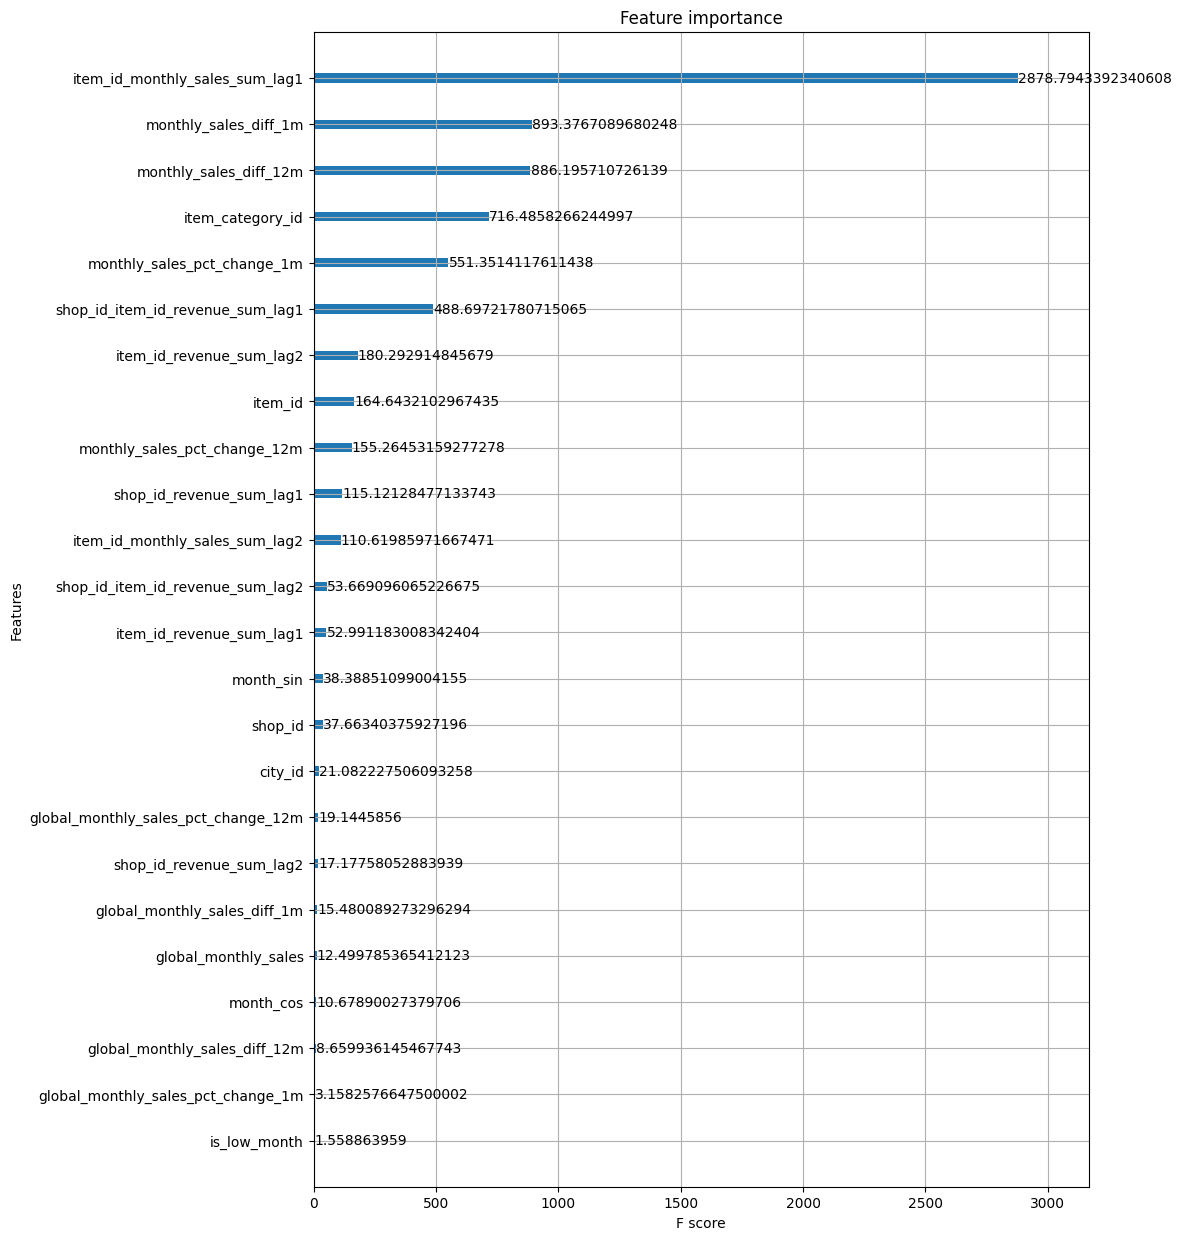

In [118]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

In [119]:
Y_train_predict = model.predict(X_train)
Y_valid_predict = model.predict(X_valid)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valid = np.sqrt(
    mean_squared_error(
        y_true = Y_valid,
        y_pred = Y_valid_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valid = str(round(rmse_valid, 3)).replace(".", "_")

In [120]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valid}")

Train RMSE: 0_924
Validation RMSE: 1_127


### Cross Validation

### Retrain Model

Reentrenamos el modelo con los datos de X_train y X_valid

In [121]:
X_full_train = pd.concat([X_train, X_valid])
Y_full_train = pd.concat([Y_train, Y_valid])

model.fit(X_full_train, Y_full_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=18,
             num_parallel_tree=1, random_state=175, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=175, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [122]:
# 1. Definir métrica negativa de RMSE
neg_rmse = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

# 2. Crear el split temporal
tscv = TimeSeriesSplit(n_splits=5, test_size=12)

# 3. Validación cruzada
scores = cross_val_score(model, X_full_train, Y_full_train, scoring=neg_rmse, cv=tscv)


# 4. Convertir a positivo
rmse_scores = -scores
rmse_scores_mean= round(rmse_scores.mean(),3)



print("RMSE por fold:", rmse_scores)
print("RMSE promedio:", rmse_scores_mean)


RMSE por fold: [1.15889955 0.54492943 0.53742207 0.90277026 0.54362469]
RMSE promedio: 0.738


### Prediction

En este apartado vamos a utilizar el modelo entrenado para hacer una predicción y posteriormente enviar el submit a Kaggle.

In [63]:
if "monthly_sales" in X_test.columns:
    X_test.drop("monthly_sales", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
X_test["monthly_sales"] = Y_test_predict

In [64]:
X_test.reset_index(inplace = True)

In [65]:
# Obtener fecha y hora actuales en formato deseado
timestamp = datetime.now().strftime("%m-%d_%H-%M")

(
    X_test[["unique_id", "monthly_sales"]]
    .to_csv(f"subm_{timestamp}_train_{rmse_train}_valida_{rmse_valid}_mean_{rmse_scores_mean}.csv", index = False)
)

In [66]:
print('CUANDO ESTES CONTENTO CON LA ELECCIÓN SUBIR EL NOTEBOOK A NUCLIO (EDA + MODELO)')

CUANDO ESTES CONTENTO CON LA ELECCIÓN SUBIR EL NOTEBOOK A NUCLIO (EDA + MODELO)
